In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
from target import build_tgt_matrix
import pandas as pd

%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
source = '/home/sobolev/nevermind/Andrey/data'
report = '/home/sobolev/nevermind/Andrey/analysis/PSTH'

In [24]:
selected_sessions = [
# frequency
'009266_hippoSIT_2023-04-17_17-04-17',  # ch17, 20 + 55 correction, 5067 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-18_10-10-37',  # ch17, 10 + 55 correction, 5682 events
'009266_hippoSIT_2023-04-18_17-03-10',  # ch17, 6 + 55 correction, 5494 events: FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-19_10-33-51',  # ch17, 4 + 55 correction, 6424 events: very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-24_16-56-55',  # ch17, 5 + 55* correction, 6165 events, frequency
'009266_hippoSIT_2023-05-02_12-22-14',  # ch20, 10 + 55 correction, 5976 events, FIXME very weird 1-2nd in target, find out
    
# duration
'009266_hippoSIT_2023-04-20_08-57-39',  # ch1, 1 + 55 correction, 6424 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-26_08-20-17',  # ch17, 12 + 55* correction, 6095 events, duration - showcase for N2 
'009266_hippoSIT_2023-05-04_19-47-15',  # ch20, 2 + 55 correction, 5678 events, duration

# COMA
'009266_hippoSIT_2023-05-04_09-11-06',  # ch17, 5 + 55* correction, 4487 events, COMA session with baseline AEPs

# Old PPC sessions
'008229_hippoSIT_2022-05-17_21-44-43',  # chs: 0, 31, 54, 56
'008229_hippoSIT_2022-05-16_20-36-44',  # chs: 0, 56
'008229_hippoSIT_2022-05-20_15-54-39',  # chs: 0, 56
'008229_hippoSIT_2022-05-18_14-36-18',  # chs: 0, 56
]

session = selected_sessions[2]
area = 'PPC'

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5name      = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, session)
if not os.path.exists(report_path):
    os.makedirs(report_path)

In [25]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])
    
with h5py.File(aeps_file, 'r') as f:
    aeps_A1 = np.array(f['A1']['aeps'])
    aeps_PPC = np.array(f['PPC']['aeps'])
    aeps_events = np.array(f['aeps_events'])
    
# TODO find better way. Remove outliers
aeps_A1[aeps_A1 > 5000]    =  5000
aeps_A1[aeps_A1 < -5000]   = -5000
aeps_PPC[aeps_PPC > 1500]  =  1500
aeps_PPC[aeps_PPC < -1500] = -1500

In [26]:
# # load metrics
AEP_metrics_lims = {}
AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_file, 'r') as f:
    grp = f[area]
    
    for metric_name in grp['raw']:
        AEP_metrics_raw[metric_name]  = np.array(grp['raw'][metric_name])
        AEP_metrics_norm[metric_name] = np.array(grp['norm'][metric_name])
        AEP_metrics_lims[metric_name] = [int(x) for x in grp['raw'][metric_name].attrs['limits'].split(',')]

In [27]:
tgt_matrix = build_tgt_matrix(tl, trials, aeps_events)

aeps_A1.shape, aeps_PPC.shape, tgt_matrix.shape

((5494, 200), (5494, 200), (65, 5))

## Read units

In [28]:
# get available units
unit_names = []
with h5py.File(h5name, 'r') as f:
    unit_names = [x for x in f['units']]
            
print(unit_names), len(unit_names)

['1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-10', '2-11', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '3-10', '3-11', '3-12', '3-13', '3-14', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '3-8', '3-9', '4-2', '4-3', '4-4', '4-5', '4-6', '5-2', '5-3', '5-4']


(None, 48)

In [29]:
# read single units
single_units = {}
spike_times = {}

with h5py.File(h5name, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        #single_units[unit_name] = instantaneous_rate(unit_times, tl[:, 0], k_width=50)

## Cross-AEPs

In [32]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

In [33]:
selected_units = ['3-12', '4-2']

In [34]:
# single corr coef
for unit_id in selected_units:
    print(np.corrcoef(single_units[unit_id][aeps_tl_idxs], AEP_metrics_norm['P3']))

[[ 1.         -0.17589612]
 [-0.17589612  1.        ]]
[[1.         0.09549401]
 [0.09549401 1.        ]]


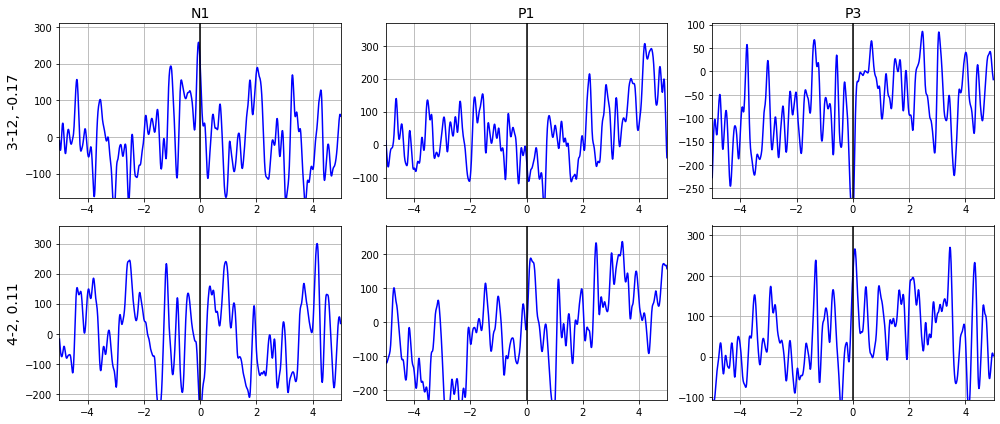

In [36]:
fig = plt.figure(figsize=(14, 3*len(selected_units)))

s_rate = 100  # Hz
t_lag  = 5  # seconds
dim = len(AEP_metrics_norm)
speed = tl[:, 3]

for i, unit_name in enumerate(selected_units):
    i_rate = single_units[unit_name]
    corr_coeff = stats.pearsonr(i_rate, speed)[0]
    
    for j, (m_name, m_vals) in enumerate(AEP_metrics_norm.items()):
        corr = signal.correlate(i_rate[aeps_tl_idxs], m_vals)
        lags = signal.correlation_lags(len(m_vals), len(i_rate[aeps_tl_idxs]))
        idx_l, idx_r = int(len(lags)/2) - t_lag*s_rate, int(len(lags)/2) + t_lag*s_rate
        y_min = 0.8*corr[idx_l:idx_r].min()
        y_max = 1.2*corr[idx_l:idx_r].max()

        ax = fig.add_subplot(len(selected_units), dim, dim*i + j+1)
        ax.plot(lags[idx_l:idx_r]/100, corr[idx_l:idx_r], color='blue')

        if i == 0:
            ax.set_title(m_name, fontsize=14)
        if j == 0:
            ax.set_ylabel("%s, %.2f" % (unit_name, corr_coeff), fontsize=14)
        ax.axvline(0, color='black')
        ax.set_xlim(-t_lag, t_lag)
        ax.set_ylim(y_min, y_max)
        ax.grid()
    
fig.tight_layout()